In [1]:
from livenote import LiveNote
from livenote_v2 import LiveNoteV2
from chroma import wav_to_chroma, wav_to_chroma_col
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ref = 'Songs/bso/bso_01.wav'
live = 'Songs/bso/bso_02.wav'
ref_seq = wav_to_chroma(ref)
live_seq = wav_to_chroma(live)

print "initializing livenote"
params = {'search_band_width': 50, 'max_run_count': 3}
debug_params = {'seq': False, 'all': False}
ln = LiveNote(ref_seq, params, debug_params)

print "calling insert"
for i in range(live_seq.shape[1]):
    cont = ln.insert(live_seq[:,i])
    if cont == "stop":
        break

initializing livenote
calling insert


In [3]:
print len(ln.path)

11354


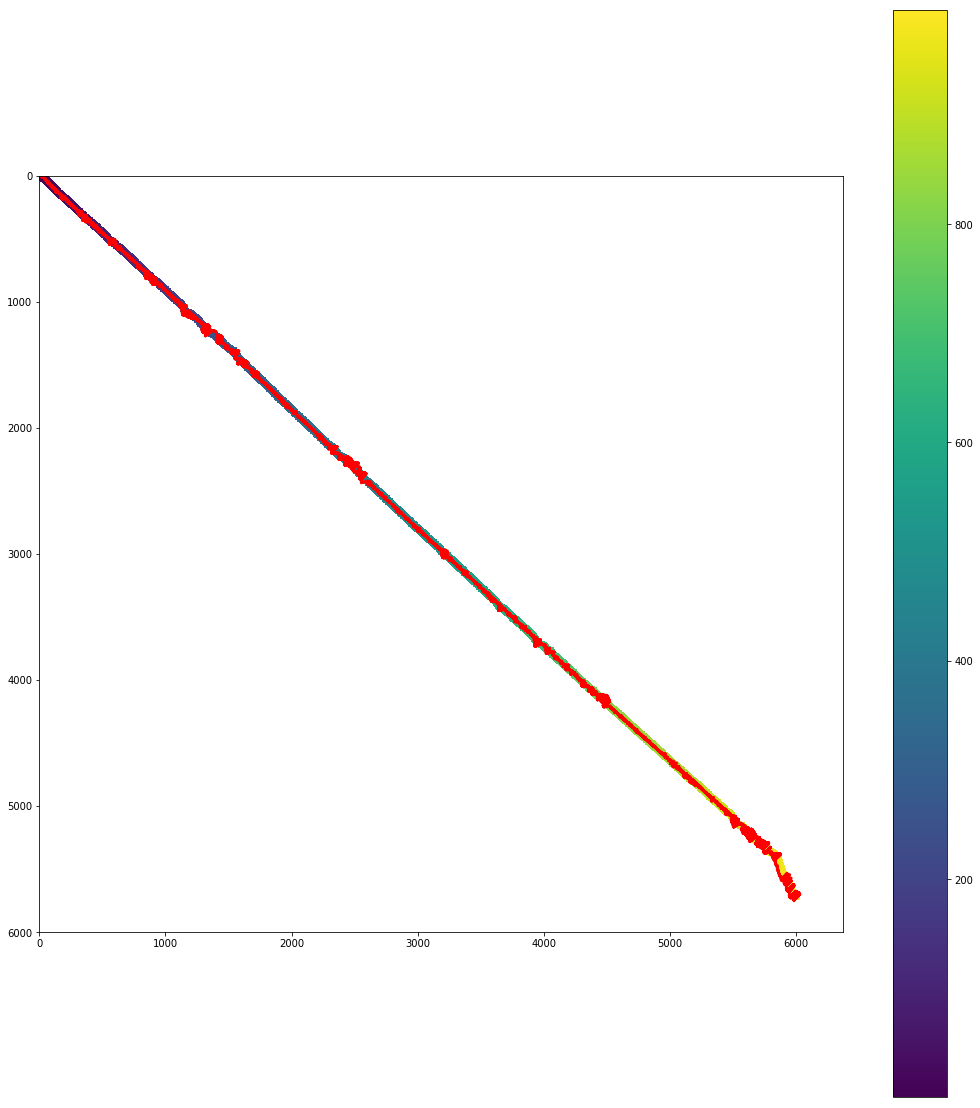

In [4]:
plt.figure(figsize=(18,20))
plt.imshow(ln.acc_cost[:6000, :])
plt.colorbar()
path = np.array(ln.path)
plt.plot(path[:,1], path[:,0], '-r', linewidth=3)
plt.show()

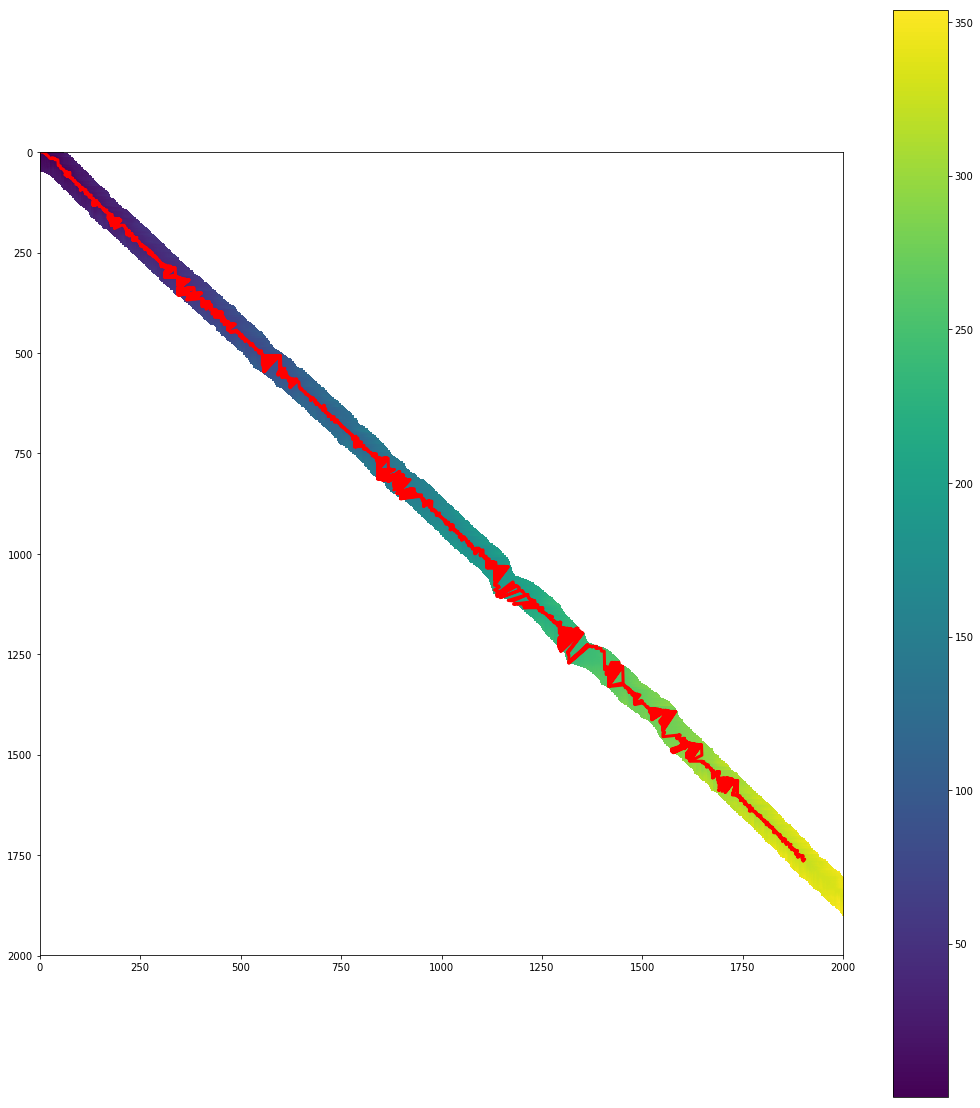

In [5]:
plt.figure(figsize=(18,20))
plt.imshow(ln.acc_cost[:2000, :2000])
plt.colorbar()
path = np.array(ln.path)
plt.plot(path[:,1][:3500], path[:,0][:3500], '-r', linewidth=3)
plt.show()

In [6]:
ln2 = LiveNoteV2(ref_seq, params, debug_params)

print "calling insert"
for i in range(live_seq.shape[1]):
    cont = ln2.insert(live_seq[:,i])
    if cont == "stop":
        break

calling insert


In [7]:
print len(ln2.path)

4290


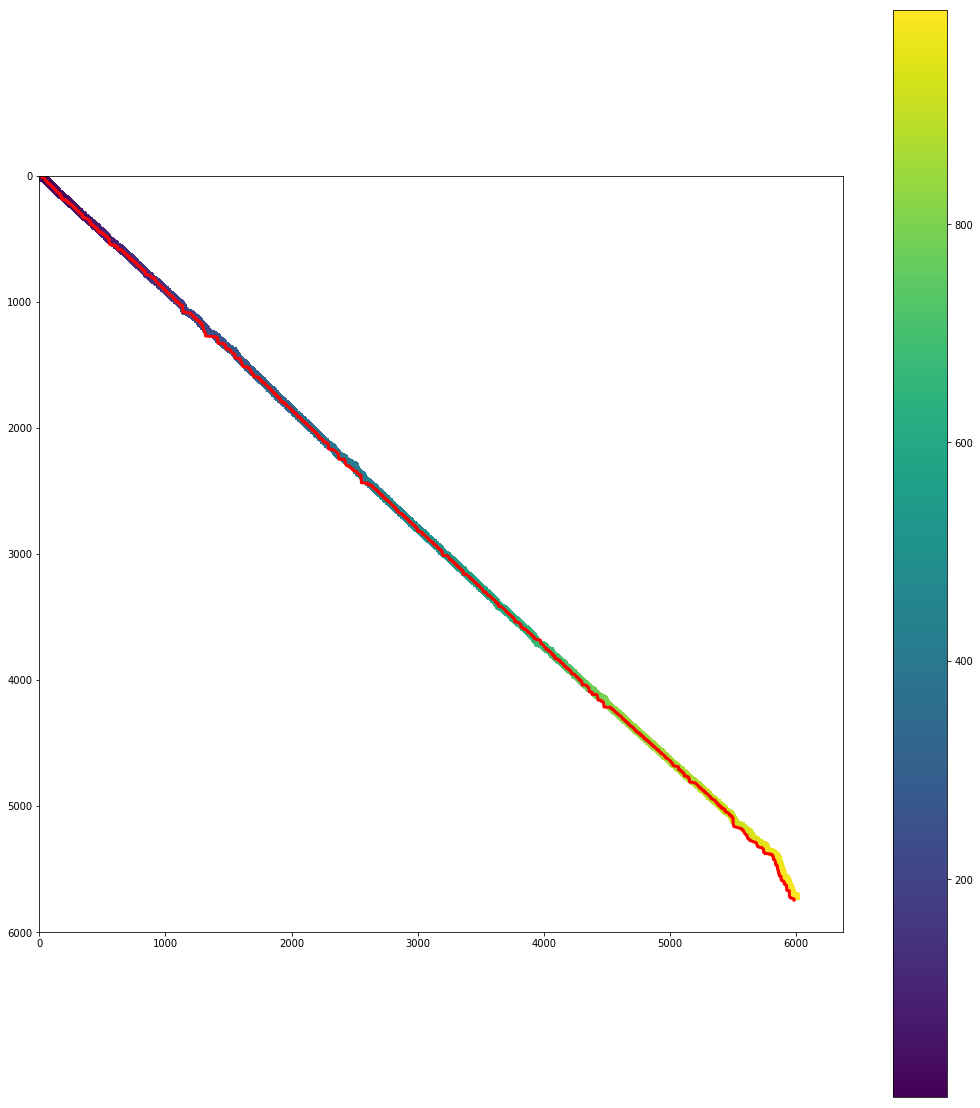

In [8]:
plt.figure(figsize=(18,20))
plt.imshow(ln2.acc_cost[:6000, :])
plt.colorbar()
path = np.array(ln2.path)
plt.plot(path[:,1], path[:,0], '-r', linewidth=3)
plt.show()

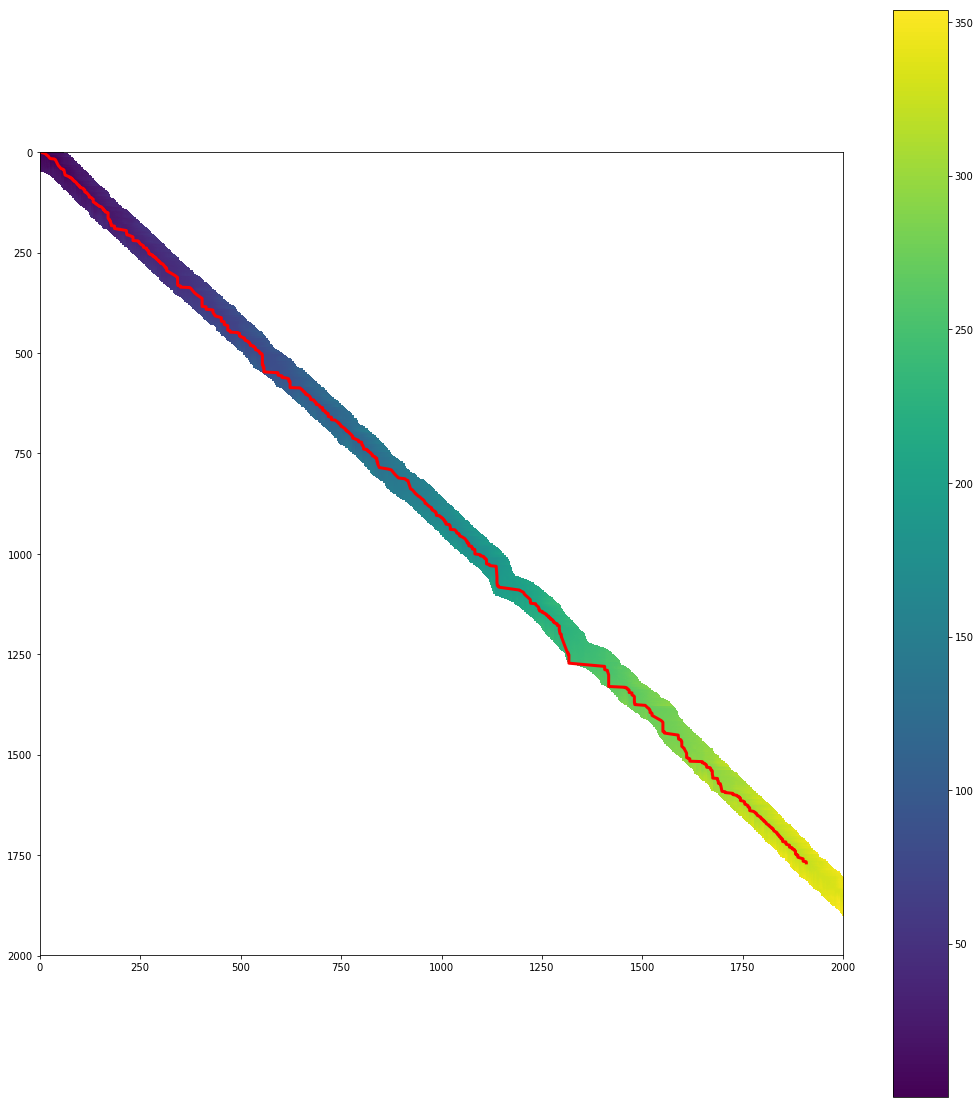

In [9]:
plt.figure(figsize=(18,20))
plt.imshow(ln2.acc_cost[:2000, :2000])
plt.colorbar()
path = np.array(ln2.path)
plt.plot(path[:,1][:1300], path[:,0][:1300], '-r', linewidth=3)
plt.show()

In [12]:
import csv

class test_simple():

    def __init__(self, ref, live, path):

        self.ref_gt_times = []
        self.ref_gt_beats = []
        self.live_gt_times = []
        self.live_gt_beats = []

        self.path = path
        
        ref_song = ref[:-4]
        print "Reference song:", ref_song
        ref_csv = ref_song + '.csv'
        live_song = live[:-4]
        print "Live song:", live_song
        live_csv = live_song + '.csv'
     
        with open(ref_csv) as ref_csv_data:
            reader = csv.reader(ref_csv_data)
            for row in reader:
                self.ref_gt_times.append(float(row[0]))
                self.ref_gt_beats.append(int(row[1]))
                
        with open(live_csv) as live_csv_data:
            reader = csv.reader(live_csv_data)
            for row in reader:
                self.live_gt_times.append(float(row[0]))
                self.live_gt_beats.append(int(row[1]))

    def get_error(self):
        error = 0
        num_off1 = 0
        num_off3 = 0
        num_off5 = 0
        num_off10 = 0
        count = 0
        num_off1_secs = 0
        num_off3_secs = 0
        num_off5_secs = 0
        num_off10_secs = 0
        for (l, r) in self.path:
            l_beat = self.get_beat(l, self.live_gt_times, self.live_gt_beats)
            r_beat = self.get_beat(r, self.ref_gt_times, self.ref_gt_beats)
            if l_beat and r_beat:
                diff = abs(l_beat - r_beat)
                error += diff ** 2

                if diff > 1:
                    num_off1 += 1
                if diff > 3:
                    num_off3 += 1
                if diff > 5:
                    num_off5 += 1
                if diff > 10:
                    num_off10 += 1

                count += 1

                seconds_off = self.get_secs_off(r_beat, l_beat)
                if seconds_off > 1:
                    num_off1_secs += 1
                if seconds_off > 3:
                    num_off3_secs += 1
                if seconds_off > 5:
                    num_off5_secs += 1
                if seconds_off > 10:
                    num_off10_secs += 1

                #print l_beat, r_beat, diff

        print "Percent incorrect (within 1 beat):", (float(num_off1) / count) * 100, "%"
        print "Percent incorrect (within 3 beats):", (float(num_off3) / count) * 100, "%"
        print "Percent incorrect (within 5 beats):", (float(num_off5) / count) * 100, "%"
        print "Percent incorrect (within 10 beats):", (float(num_off10) / count) * 100, "%"
        print "Percent incorrect (within 1 second):", (float(num_off1_secs) / count) * 100, "%"
        print "Percent incorrect (within 3 seconds):", (float(num_off3_secs) / count) * 100, "%"
        print "Percent incorrect (within 5 seconds):", (float(num_off5_secs) / count) * 100, "%"
        print "Percent incorrect (within 10 seconds):", (float(num_off10_secs) / count) * 100, "%"
        return (float(num_off3_secs) / count) * 100
                

    def get_beat(self, sample, gt_times, gt_beats):
        # convert sample to time
        time = sample * (2048 / 22050.)
        for i in range(len(gt_times)):
            if i == 0:
                if time <= gt_times[i]:
                    if gt_times[i] != 0:
                        frac = float(gt_times[i] - time) / (gt_times[i] - 0)
                    else:
                        frac = 0
                    return gt_beats[i] - frac
            else:
                if gt_times[i-1] <= time <= gt_times[i]:
                    frac = float(gt_times[i] - time) / (gt_times[i] - gt_times[i-1])
                    return gt_beats[i] - frac

        return None

    def get_time(self, beat):
        time = self.live_gt_times[int(beat)]
        if int(beat) + 1 < len(self.live_gt_times):
            time += (beat%1) * (self.live_gt_times[int(beat) + 1] - self.live_gt_times[int(beat)])
        return time

    def get_secs_off(self, ref_beat, live_beat):
        return abs(self.get_time(ref_beat) - self.get_time(live_beat))

In [16]:
ln_path = np.array(ln.path)
ln_test = test_simple(ref, live, ln_path)
ln_test.get_error()

Reference song: Songs/bso/bso_01
Live song: Songs/bso/bso_02
Percent incorrect (within 1 beat): 25.8603002891 %
Percent incorrect (within 3 beats): 6.47206938357 %
Percent incorrect (within 5 beats): 0.373029935652 %
Percent incorrect (within 10 beats): 0.0 %
Percent incorrect (within 1 second): 30.0941900588 %
Percent incorrect (within 3 seconds): 9.42833162361 %
Percent incorrect (within 5 seconds): 1.98638440735 %
Percent incorrect (within 10 seconds): 0.0 %


9.428331623612793

In [17]:
ln2_path = np.array(ln2.path)
ln2_test = test_simple(ref, live, ln2_path)
ln2_test.get_error()

Reference song: Songs/bso/bso_01
Live song: Songs/bso/bso_02
Percent incorrect (within 1 beat): 16.3280662152 %
Percent incorrect (within 3 beats): 3.38600451467 %
Percent incorrect (within 5 beats): 0.275896664159 %
Percent incorrect (within 10 beats): 0.0 %
Percent incorrect (within 1 second): 19.8896413343 %
Percent incorrect (within 3 seconds): 4.589917231 %
Percent incorrect (within 5 seconds): 1.22899423125 %
Percent incorrect (within 10 seconds): 0.0 %


4.5899172310007526